# COVID-19 Vaccine Sentiment Analysis with fastai
In this notebook we will perform sentiment analysis on tweets about COVID-19 vaccines using the [`fastai`](https://docs.fast.ai/) library. I will provide a brief overview of the process here, but a much more in-depth explanation of NLP with [`fastai`](https://docs.fast.ai/) can be found in [lesson 8](https://course.fast.ai/videos/?lesson=8) of the [`fastai`](https://docs.fast.ai/) course. For convenience clicking on inline code written like [`this`](https://docs.fast.ai/tutorial.text.html) will take you to the relevant part of the [`fastai`](https://docs.fast.ai/) documentation where appropriate.

## Transfer learning in NLP - the ULMFiT approach

We will be making use of *transfer learning* to help us create a model to analyse tweet sentiment. The idea behind transfer learning is that neural networks learn information that generalises to new problems, [particularly the early layers of the network](https://arxiv.org/pdf/1311.2901.pdf). In computer vision, for example, we can take a model that was trained on the ImageNet dataset to recognise different features of images such as circles, then apply that to a smaller dataset and *fine-tune* the model to be more suited to a specific task (e.g. classifying images as cats or dogs). This technique allows us to train neural networks much faster and with far less data than we would otherwise need.

In 2018 [a paper](https://arxiv.org/abs/1801.06146) introduced a transfer learning technique for NLP called 'Universal Language Model Fine-Tuning' (ULMFiT). The approach is as follows:
1. Train a *language model* to predict the next word in a sentence. This step is already done for us; with [`fastai`](https://docs.fast.ai/) we can download a model that has been pre-trained for this task on millions of Wikipedia articles. A good language model already knows a lot about how language works in general - for  instance, given the sentence 'Tokyo is the capital of', the model might predict 'Japan' as the next word. In this case the model understands that Tokyo is closely related to Japan and that 'capital' refers to 'city' here instead of 'upper-case' or 'money'.
2. Fine-tune the language model to a more specific task. The pre-trained language model is good at understanding Wikipedia English, but Twitter English is a bit different. We can take the information the Wikipedia model has learned and apply that to a Twitter dataset to get a Twitter language model that is good at predicting the next word in a tweet.
3. Fine-tune a *classification model* to identify sentiment using the pre-trained language model. The idea here is that since our language model already knows a lot about Twitter English, it's not a huge leap from there to train a classifier that understands that 'love' refers to positive sentiment and 'hate' refers to negative sentiment. If we tried to train a classifier without using a pre-trained model it would have to learn the whole language from scratch first, which would be very difficult and time consuming.

<img alt="Diagram of the ULMFiT process (source: course.fast.ai)" width="700" align="left" caption="The ULMFiT process" id="ulmfit_process" src=https://i.imgur.com/8XLluAn.png>

This notebook will walk through steps 2 and 3 with [`fastai`](https://docs.fast.ai/). Afterwards we can use our new classifier to analyse sentiment in the COVID-19 vaccine tweets and compare changes in sentiment over time to the progress of vaccination in different countries.

## Loading the data
First, let's import [`fastai`](https://docs.fast.ai/)'s [`text`](https://docs.fast.ai/tutorial.text.html) module and take a look at our data.

In [6]:
from fastai.text.all import *

In [7]:
path = Path('/kaggle/input/')
path.ls()

(#3) [Path('/kaggle/input/all-covid19-vaccines-tweets'),Path('/kaggle/input/complete-tweet-sentiment-extraction-data'),Path('/kaggle/input/covid-world-vaccination-progress')]

In [8]:
vax_tweets = pd.read_csv(path/'all-covid19-vaccines-tweets/vaccination_all_tweets.csv')
vax_tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


We could use the `text` column of this dataset to train a Twitter language model, but since our end goal is sentiment analysis we will need to find another dataset that also contains sentiment labels to train our classifier. Let's use ['Complete Tweet Sentiment Extraction Data'](https://www.kaggle.com/maxjon/complete-tweet-sentiment-extraction-data), which contains 40,000 tweets labelled as either negative, neutral or positive sentiment. For more accurate results you could use the ['sentiment140'](https://www.kaggle.com/kazanova/sentiment140) dataset instead, which contains 1.6m tweets labelled as either positive or negative.

In [9]:
tweets = pd.read_csv(path/'complete-tweet-sentiment-extraction-data/tweet_dataset.csv')
tweets.head()

,textID,sentiment,author,text,old_text,aux_id,new_sentiment,selected_text
0,1956967341,empty,xoshayzers,i know i was listenin to bad habit earlier and i started freakin at his part =[,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,p1000000000,NaN,NaN
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed with a headache ughhhh...waitin on your call...,c811396dc2,negative,headache
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"We want to trade with someone who has Houston tickets, but no one will.","@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",82565a56d3,neutral,"We want to trade with someone who has Houston tickets, but no one will."


For our language model, the only input we need is the tweet text. As we will see in a moment [`fastai`](https://docs.fast.ai/) can handle text preprocessing and tokenization for us, but it might be a good idea to remove things like twitter handles, urls, hashtags and emojis first. You could experiment with leaving these in for your own models and see how it affects the results. There are also some rows with blank tweets which need to be removed.

We ideally want the language model to learn not just about tweet language, but more specifically about vaccine tweet language. We can therefore use text from both datasets as input for the language model. For the classification model we need to remove all rows with missing sentiment, however.

In [10]:
# Code via https://www.kaggle.com/garyongguanjie/comments-analysis
def de_emojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

# Code via https://www.kaggle.com/pawanbhandarkar/generate-smarter-word-clouds-with-log-likelihood
def tweet_proc(df, text_col='text'):
    df['orig_text'] = df[text_col]
    # Remove twitter handles
    df[text_col] = df[text_col].apply(lambda x:re.sub('@[^\s]+','',x))
    # Remove URLs
    df[text_col] = df[text_col].apply(lambda x:re.sub(r"http\S+", "", x))
    # Remove emojis
    df[text_col] = df[text_col].apply(de_emojify)
    # Remove hashtags
    df[text_col] = df[text_col].apply(lambda x:re.sub(r'\B#\S+','',x))
    return df[df[text_col]!='']

# Clean the text data and combine the dfs
tweets = tweets[['old_text', 'new_sentiment']].rename(columns={'old_text':'text', 'new_sentiment':'sentiment'})
vax_tweets['sentiment'] = np.nan
tweets = tweet_proc(tweets)
vax_tweets = tweet_proc(vax_tweets)
df_lm = tweets[['text', 'sentiment']].append(vax_tweets[['text', 'sentiment']])
df_clas = df_lm.dropna(subset=['sentiment'])
print(len(df_lm), len(df_clas))

109642 31323


In [11]:
df_clas.head()

,text,sentiment
1,Layin n bed with a headache ughhhh...waitin on your call...,negative
2,Funeral ceremony...gloomy friday...,negative
3,wants to hang out with friends SOON!,positive
4,"We want to trade with someone who has Houston tickets, but no one will.",neutral
5,Re-pinging why didn't you go to prom? BC my bf didn't like my friends,negative


## Training a language model
To train our language model we can use self-supervised learning; we just need to give the model some text as an independent variable and [`fastai`](https://docs.fast.ai/) will automatically preprocess it and create a dependent variable for us. We can do this in one line of code using the [`DataLoaders`](https://docs.fast.ai/data.core.html#DataLoaders) class, which converts our input data into a [`DataLoader`](https://docs.fast.ai/data.load.html#DataLoader) object that can be used as an input to a [`fastai`](https://docs.fast.ai/) [`Learner`](https://docs.fast.ai/learner.html#Learner).

In [12]:
dls_lm = TextDataLoaders.from_df(df_lm, text_col='text', is_lm=True, valid_pct=0.1)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Here we told [`fastai`](https://docs.fast.ai/) that we are working with text data, which is contained in the `text` column of a [`pandas`](https://pandas.pydata.org/docs/) [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) called `df_lm`. We set [`is_lm=True`](https://docs.fast.ai/text.data.html#TextDataLoaders) since we want to train a language model, so [`fastai`](https://docs.fast.ai/) needs to label the input data for us. Finally, we told [`fastai`](https://docs.fast.ai/) to hold out a random 10% of our data for a validation set using [`valid_pct=0.1`](https://docs.fast.ai/text.data.html#TextDataLoaders).

Let's take a look at the first two rows of the [`DataLoader`](https://docs.fast.ai/data.load.html#DataLoader) using [`show_batch`](https://docs.fast.ai/data.core.html#TfmdDL.show_batch).

In [13]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj bombshell : xxmaj chief xxmaj medical xxmaj officer xxmaj admits xxup mrna xxmaj alters xxup dna xxbos is watching big xxunk big quiz , rather xxunk , but downloading a dvd so have to wait till finished till i can go to bed xxbos xxmaj world xxmaj civil xxmaj defence xxmaj day \n\n . \n . \n . xxbos xxmaj the results of 3rd phase of trial of xxmaj covaxin","xxmaj bombshell : xxmaj chief xxmaj medical xxmaj officer xxmaj admits xxup mrna xxmaj alters xxup dna xxbos is watching big xxunk big quiz , rather xxunk , but downloading a dvd so have to wait till finished till i can go to bed xxbos xxmaj world xxmaj civil xxmaj defence xxmaj day \n\n . \n . \n . xxbos xxmaj the results of 3rd phase of trial of xxmaj covaxin shows"
1,"nice xxbos i hate that i am so stinkin tired everyday ! xxmaj it 's so hard to get up … i thought i was supposed to start getting energy back now . xxbos why must the weather b so nice and then so bad all in 1 minute xxbos released the results of from its huge real - world study , which shows : \n\n 67 % effecti xxbos xxmaj my","xxbos i hate that i am so stinkin tired everyday ! xxmaj it 's so hard to get up … i thought i was supposed to start getting energy back now . xxbos why must the weather b so nice and then so bad all in 1 minute xxbos released the results of from its huge real - world study , which shows : \n\n 67 % effecti xxbos xxmaj my windows"


We have a new column, `text_`, which is `text` offset by one. This is the dependent variable [`fastai`](https://docs.fast.ai/) created for us. By default [`fastai`](https://docs.fast.ai/) uses *word tokenization*, which splits the text on spaces and punctuation marks and breaks up words like *can't* into two separate tokens. [`fastai`](https://docs.fast.ai/) also has some special tokens starting with 'xx' that are designed to make things easier for the model; for example [`xxmaj`](https://docs.fast.ai/text.data.html) indicates that the next word begins with a capital letter and [`xxunk`](https://docs.fast.ai/text.data.html) represents an unknown word that doesn't appear in the vocabulary very often. You could experiment with *subword tokenization* instead, which will split the text on commonly occuring groups of letters instead of spaces. This might help if you wanted to leave hashtags in since they often contain multiple words joined together with no spaces, e.g. #CovidVaccine. The [`fastai`](https://docs.fast.ai/) tokenization process is explained in much more detail [here](https://youtu.be/WjnwWeGjZcM?t=626) for those interested.

### Fine-tuning the language model
The next step is to create a language model using [`language_model_learner`](https://docs.fast.ai/text.learner.html#language_model_learner).

In [14]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

Here we passed [`language_model_learner`](https://docs.fast.ai/text.learner.html#language_model_learner) our [`DataLoaders`](https://docs.fast.ai/data.core.html#DataLoaders), `dls_lm`, and the pre-trained [RNN](https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn) model, [*AWD_LSTM*](https://docs.fast.ai/text.models.awdlstm.html), which is built into [`fastai`](https://docs.fast.ai/). [`drop_mult`](https://docs.fast.ai/text.learner.html#text_classifier_learner) is a multiplier applied to all [dropouts](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) in the AWD_LSTM model to reduce overfitting. For example, by default [`fastai`](https://docs.fast.ai/)'s AWD_LSTM applies [`EmbeddingDropout`](https://docs.fast.ai/text.models.awdlstm.html#EmbeddingDropout) with 10% probability (at the time of writing), but we told [`fastai`](https://docs.fast.ai/) that we want to reduce that to 3%. The [`metrics`](https://docs.fast.ai/metrics.html) we want to track are *perplexity*, which is the exponential of the loss (in this case cross entropy loss), and *accuracy*, which tells us how often our model predicts the next word correctly. We can also train with fp16 to use less memory and speed up the training process.

We can find a good learning rate for training using [`lr_find`](https://docs.fast.ai/callback.schedule.html#Learner.lr_find) and use that to fit our model.

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.02754228748381138)

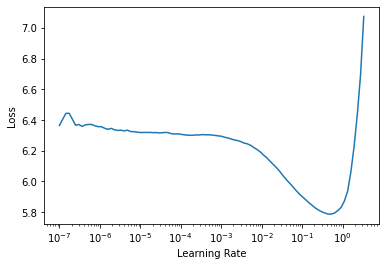

In [15]:
learn.lr_find()

When we created our [`Learner`](https://docs.fast.ai/learner.html#Learner) the embeddings from the pre-trained AWD_LSTM model were merged with random embeddings added for words that weren't in the vocabulary. The pre-trained layers were also automatically frozen for us. Using [`fit_one_cycle`](https://docs.fast.ai/callback.schedule.html#Learner.fit_one_cycle) with our [`Learner`](https://docs.fast.ai/learner.html#Learner) will train only the *new random embeddings* (i.e. words that are in our Twitter vocab but not the Wikipedia vocab) in the last layer of the neural network.

In [16]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.199480,4.114621,0.283703,61.229015,02:20


After one epoch our language model is predicting the next word in a tweet around 25% of the time - not too bad! We can [`unfreeze`](https://docs.fast.ai/learner.html#Learner.unfreeze) the entire model, find a more suitable learning rate and train for a few more epochs to improve the accuracy further.

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=5.754399353463668e-06)

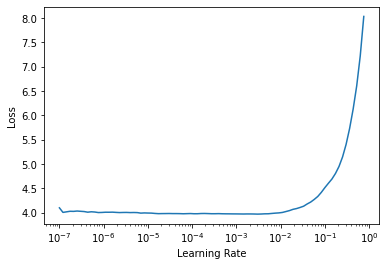

In [17]:
learn.unfreeze()
learn.lr_find()

In [18]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.832574,3.976410,0.299593,53.325249,02:34
1,3.694468,3.882712,0.313084,48.555737,02:32
2,3.499271,3.837519,0.323230,46.410206,02:31
3,3.378342,3.857669,0.323332,47.354820,02:32


After a bit more training we can predict the next word in a tweet around 29% of the time. Let's test the model out by using it to write some random tweets (in this case it will generate some text following 'I love').

In [19]:
# Text generation using the language model
TEXT = "I love"
N_WORDS = 30
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i love my life . My mum left it at home but i do n't have it . Second dose . Thank you ! I 'm
i love you . i love you , i love you too ! Just got my first dose of the vaccine ! ! Thank you Modi ji !


Let's save the model *encoder* so we can use it to fine-tune our classifier. The encoder is all of the model except for the final layer, which converts activations to probabilities of picking each token in the vocabulary. We want to keep the knowledge the model has learned about tweet language but we won't be using our classifier to predict the next word in a sentence, so we won't need the final layer any more.

In [20]:
learn.save_encoder('finetuned_lm')

## Training a sentiment classifier
To get the [`DataLoaders`](https://docs.fast.ai/data.core.html#DataLoaders) for our classifier let's use the [`DataBlock`](https://docs.fast.ai/tutorial.datablock.html#Text) API this time, which is more customisable.

In [21]:
dls_clas = DataBlock(
    blocks = (TextBlock.from_df('text', seq_len=dls_lm.seq_len, vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('sentiment'),
    splitter=RandomSplitter()
).dataloaders(df_clas, bs=64)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


To use the API, [`fastai`](https://docs.fast.ai/) needs the following:
* [`blocks`](https://docs.fast.ai/data.block.html#TransformBlock):
    * [`TextBlock`](https://docs.fast.ai/text.data.html#TextBlock): Our x variable will be text contained in a [`pandas`](https://pandas.pydata.org/docs/) [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). We want to use the same sequence length and vocab as the language model [`DataLoaders`](https://docs.fast.ai/data.core.html#DataLoaders) so we can make use of our pre-trained model.
    * [`CategoryBlock`](https://docs.fast.ai/data.block.html#CategoryBlock): Our y variable will be a single-label category (negative, neutral or positive sentiment).
* [`get_x`](https://docs.fast.ai/data.transforms.html#ColReader), [`get_y`](https://docs.fast.ai/data.transforms.html#ColReader): Get data for the model by reading the `text` and `sentiment` columns from the [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).
* [`splitter`](https://docs.fast.ai/data.transforms.html#RandomSplitter): We will use [`RandomSplitter()`](https://docs.fast.ai/data.transforms.html#RandomSplitter) to randomly split the data into a training set (80% by default) and a validation set (20%).
* [`dataloaders`](https://docs.fast.ai/data.block#DataBlock.dataloaders): Builds the [`DataLoaders`](https://docs.fast.ai/data.core.html#DataLoaders) using the [`DataBlock`](https://docs.fast.ai/tutorial.datablock.html#Text) template we just defined, the *df_clas* [`DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) and a batch size of 64.

We can call show batch as before; this time the dependent variable is sentiment.

In [22]:
dls_clas.show_batch(max_n=2)

,text,category
0,xxbos xxup pirate xxup voice : xxrep 3 a xxrep 3 r xxrep 3 g xxrep 3 h xxrep 3 ! i 4got xxup my xxup damn xxup wallet xxup at xxup work xxup xxunk xxrep 3 ! xxup dammit xxrep 3 ! xxup so xxup close xxup yet xxup so xxup far xxrep 3 ! xxup now xxup i m xxup starving xxrep 3 !,negative
1,"xxbos xxup xxunk xxup rocked xxup nashville xxup tonite .. one xxup thing xxup sucked , xxup no xxup xxunk ! xxup like xxup in xxup the 80 's xxup they xxup still xxup have a xxup fun xxup show . xxup xxunk xxup has xxup that xxup hott xxup bad xxup boy xxup look",neutral


Initialising the [`Learner`](https://docs.fast.ai/learner.html#Learner) is similar to before, but in this case we want a [`text_classifier_learner`](https://docs.fast.ai/text.learner.html#text_classifier_learner).

In [23]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

Finally, we want to load the encoder from the language model we trained earlier, so our classifier uses pre-trained weights.

In [24]:
learn = learn.load_encoder('finetuned_lm')

### Fine-tuning the classifier
Now we can train the classifier using *discriminative learning rates* and *gradual unfreezing*, which has been found to give better results for this type of model. First let's freeze all but the last layer:

In [25]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.835571,0.763223,0.663793,00:38


Now freeze all but the last two layers:

In [26]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.715596,0.630619,0.731641,00:38


Now all but the last three:

In [27]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.634123,0.573182,0.766762,00:40


Finally, let's unfreeze the entire model and train a bit more:

In [28]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.592252,0.562723,0.771232,00:42
1,0.541789,0.554456,0.776341,00:42
2,0.524112,0.557768,0.774266,00:41


In [29]:
learn.save('classifier')

Path('models/classifier.pth')

Our model correctly predicts sentiment around 75% of the time. We could perhaps do better with a larger dataset as mentioned earlier, or different model hyperparameters. It might be worth experimenting with this yourself to see if you can improve the accuracy.

We can quickly sense check the model by calling [`predict`](https://docs.fast.ai/learner.html#Learner.predict), which returns the predicted sentiment, the index of the prediction and predicted probabilities for negative, neutral and positive sentiment.

In [30]:
learn.predict("I love")

('positive', tensor(2), tensor([0.0011, 0.0039, 0.9950]))

In [31]:
learn.predict("I hate")

('negative', tensor(0), tensor([0.9879, 0.0085, 0.0036]))

## Analysing the tweets
To carry out sentiment analysis on the vaccine tweets, we can add them to the [`DataLoaders`](https://docs.fast.ai/data.core.html#DataLoaders) as a test set:

In [32]:
pred_dl = dls_clas.test_dl(vax_tweets['text'])

We can then make predictions using [`get_preds`](https://docs.fast.ai/learner.html#Learner.get_preds):

In [33]:
preds = learn.get_preds(dl=pred_dl)

Let's go ahead and check out the results.

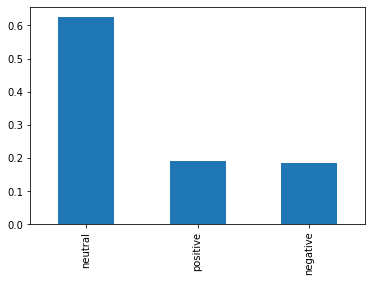

In [34]:
# Get predicted sentiment
vax_tweets['sentiment'] = preds[0].argmax(dim=-1)
vax_tweets['sentiment'] = vax_tweets['sentiment'].map({0:'negative', 1:'neutral', 2:'positive'})

# Convert dates
vax_tweets['date'] = pd.to_datetime(vax_tweets['date'], errors='coerce').dt.date

# Save to csv
vax_tweets.to_csv('vax_tweets_sentiment.csv')

# Plot sentiment value counts
vax_tweets['sentiment'].value_counts(normalize=True).plot.bar();

We can see that the predominant sentiment is neutral, with more positive tweets than negative. It's encouraging that negative sentiment isn't higher! We can also visualise how sentiment changes over time:

In [35]:
# Remove today's date since data is incomplete
today = pd.Timestamp.today().date()
vax_tweets = vax_tweets[vax_tweets['date']!=today]

# Get counts of number of tweets by sentiment for each date
timeline = vax_tweets.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index().dropna()

# Plot results
import plotly.express as px
fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},
             title='Timeline showing sentiment of tweets about COVID-19 vaccines')
fig.show()

There was a big spike in the number of tweets on March 1st 2021, so let's investigate further.

## Timeline analysis
A lot of the tweets appear to be from users in India:

In [36]:
spike = vax_tweets[vax_tweets['date'].astype(str)=='2021-03-01']
spike['user_location'].value_counts(ascending=False).head(10)

India               258
New Delhi, India    138
patna                52
Mumbai, India        48
New Delhi            46
Bengaluru, India     32
Mumbai               28
Delhi                26
Hyderabad, India     24
Pune, India          22
Name: user_location, dtype: int64

In [37]:
spike = spike.sort_values('user_location', ascending=False)
spike['orig_text'].head()

18084                        Before magreact, do the research how the vaccine works, regardless the brands and the efficacy rates. #TheVaccineIsSafe #Sinovac
17555          I find this Photo by @cpimspeak\nTo be offensive and degrading , \nIt is depicting something truly against the commun… https://t.co/X51R4sFQYq
15285                 🇮🇳 PM Shri @narendramodi took his first dose of the #COVID19 #Vaccine at AIIMS Delhi today.\nHe led the way in… https://t.co/tKLRgz3vml
16532          Got call at 9 am from health department and mom got #COVAXIN shot at 1 pm.\n\nThey do really care about their citizen… https://t.co/VdMUMXS9Nx
16901    #mRNAvaccine #PfizerBionTech\n#Moderna #Katalinkariko\n#NianshuangWang #Mclellan\n\nAs for J&amp;J, Astrazeneca, the effcti… https://t.co/tK1U6LFboZ
Name: orig_text, dtype: object

It looks like Indian Prime Minister Narendra Modi received the first dose of Indian developed Covaxin on 1st March. No wonder there were lots of tweets! To dig deeper, let's plot timelines for each vaccine indvidually.

### Covaxin

In [38]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine - not very helpful!
def filtered_timeline(df, vax, title):
    df = df.dropna()
    title_str = 'Timeline showing sentiment of tweets about the '+title+' vaccine'
    df_filt = pd.DataFrame()
    for o in vax:
        df_filt = df_filt.append(df[df['orig_text'].str.lower().str.contains(o)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['orig_text'].str.lower().str.contains(o)]
    df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index()
    fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},title=title_str)
    fig.show()
    return df_filt

covaxin = filtered_timeline(vax_tweets, ['covaxin'], title='Covaxin')

In [39]:
# Function to filter the data to a single date and print tweets from users with the most followers
def date_filter(df, date):
    return df[df['date'].astype(str)==date].sort_values('user_followers', ascending=False)[['date' ,'orig_text']]

def date_printer(df, dates, num=10): 
    for date in dates:
        display(date_filter(df, date).head(num))

date_printer(covaxin, ['2021-03-01', '2021-03-03'])

,date,orig_text
18936,2021-03-01,"""Felt secure, will travel safely"" EAM @DrSJaishankar receives his first shot of #Covaxin today \n\n#COVID19Vaccine… https://t.co/mkNsMDuJ5a"
17463,2021-03-01,#Watch | PM @NarendraModi was administered the first dose of Bharat Biotech’s #COVAXIN at AIIMS. \n\nThe vaccine was… https://t.co/Du3exryYQw
13382,2021-03-01,"@nistula Sources in the govt say PM #NarendraModi took the Indian researched and made #Covaxin by #BharatBiotech,ad… https://t.co/Z2nkbIfdRg"
13107,2021-03-01,"PM #NarendraModi took the first shot of #COVAXIN , the Indian researched and produced anti-COVID19 vaccine at AIIMS… https://t.co/0ORXTDXGSP"
18912,2021-03-01,There are two #CovidVaccines that are being used in India right now - Bharat Biotech's #Covaxin and Serum Institute… https://t.co/yqHUdBSebB
18960,2021-03-01,External Affairs Minister Jaishankar receives first dose of #Covaxin.\n#CovidVaccine #vaccination \n#LiveUpdates here… https://t.co/bTp57fZwML
18750,2021-03-01,"A 100-year-old resident of #Hyderabad, Jaidev Chowdhry, received his first dose of the Covid-19 vaccine, #Covaxin,… https://t.co/sQui1oMkFX"
18700,2021-03-01,"#PMModi took the first does of #Covid19 vaccine, #Covaxin, today. #NewsTrack #Video\nhttps://t.co/I2GTmtsGnt"
18666,2021-03-01,#PMModi took the first dose of #Covaxin today. Will this give the necessary boost to #vaccination drive in India? W… https://t.co/b26yz03azM
18803,2021-03-01,#PMModi flagged off the second phase of #Covid19 #vaccination today as he took his first dose of #Covaxin at #AIIMS… https://t.co/5F1OcGiJmn


,date,orig_text
20792,2021-03-03,"#Covaxin 81% Effective, Works Against UK Variant, Claims Bharat Biotech \n\nRead more: https://t.co/8XogSMns7c https://t.co/GmjX8APbYM"
20388,2021-03-03,"“The data is quite encouraging”: Dr Rachna Kucheria, Epidemiologist, on #Covaxin’s efficacy data https://t.co/hVT667gizB"
20403,2021-03-03,"“The numbers are extremely promising at this stage”: Dr Shekhar C Mande, Director General, CSIR, on #Covaxin's effi… https://t.co/rFoRhl1IEh"
20696,2021-03-03,"#Covaxin's Phase 3 Trial Results Out! #Covid19 Vaccine Efficacy Up At 81%, Says Bharat Biotech\n\nDetails:… https://t.co/FZGlK4PWYD"
20411,2021-03-03,"For those like me who were concerned that #Covaxin was being deployed before its third phase trials were concluded,… https://t.co/AryEWwcCV5"
20563,2021-03-03,"#Covaxin demonstrates the prowess of Atmanirbhar Bharat, says ICMR chief\n\n#COVID19Vaccine \n\nhttps://t.co/ITUyBPekvz https://t.co/kmbmUGf4X3"
20349,2021-03-03,India's vaccine maker Bharat Biotech said Wed its #covid19 #vaccine #Covaxin has demonstrated 81% interim efficacy… https://t.co/9egL9TJIV5
20380,2021-03-03,#Covaxin is one of the two vaccines that have been granted emergency use approval in India\n#CoronaVaccine… https://t.co/9lKj4Sn1Of
20850,2021-03-03,"Bharat Biotech announces phase 3 results of Covaxin, shows 81% efficacy. \n#5iveLive with @ShivAroor \n#Covaxin… https://t.co/D2yxrNb9Nf"
20671,2021-03-03,.@BharatBiotech announces the phase 3 results of its #CoronavirusVaccine #Covaxin; claims the shots demonstrated an… https://t.co/przGWrxAmN


As we can see, Modi wasn't the only person to make news on March 1st; India's External Affairs Minister and a 100-year-old Hyderabad resident also received their first dose of Covaxin. On March 3rd, phase 3 trial results for Covaxin were published, showing 81% efficacy. It makes sense for there to be a spike in the number of neutral and positive tweets about Covaxin on those dates!

### Sinovac

In [40]:
sinovac = filtered_timeline(vax_tweets, ['sinovac'], title='Sinovac')

Some notable dates:

In [41]:
date_printer(sinovac, ['2021-02-22', '2021-02-28', '2021-03-01', '2021-03-03', '2021-03-08'], 3)

,date,orig_text
11715,2021-02-22,Thai PM Prayut Chan-o-cha possibly among first to receive #Sinovac COVID-19 vaccine. #Thailand… https://t.co/sWKjP3no4i
11757,2021-02-22,"Carrie Lam, Chief Executive of #HongKong SAR, received her first jab of the #Sinovac COVID-19 vaccine https://t.co/CON1DIeVyo"
11765,2021-02-22,"The #Philippines has officially approved the emergency use of China's #Sinovac #COVID19 vaccine, the country's Food… https://t.co/TnyK1pphxE"


,date,orig_text
16270,2021-02-28,#Thai deputy PM and ministers are part of the first group to be vaccinated with the #Sinovac COVID-19 vaccine from… https://t.co/dV6gsk5KKk
16253,2021-02-28,"China has provided Mexico with 1 million doses of #Sinovac vaccines in two batches in a month, which serves as a st… https://t.co/2u60IJHnhs"
16254,2021-02-28,Second batch of #Sinovac vaccines produced by China arrived in Mexico on Saturday local time and was warmly receive… https://t.co/6oJau3Kcts


,date,orig_text
16806,2021-03-01,#Philippine General Hospital (PGH) Director Dr. Gerardo Legaspi received China's #Sinovac coronavirus vaccine on Mo… https://t.co/20g5Oj71or
16779,2021-03-01,The #Philippines kicked off vaccination drive with China’s #Sinovac #COVID19 vaccine on Monday. Philippine General… https://t.co/s6R6y1NmBp
16818,2021-03-01,"A batch of #Sinovac #vaccine donated by China arrived in the #Philippines on Sunday, the first COVID-19 vaccine to… https://t.co/3OqsI0yF8N"


,date,orig_text
19152,2021-03-03,Brazilian soccer legend #Pele on Tuesday received his first dose of a COVID-19 vaccine produced by China's #Sinovac… https://t.co/QMZu6bvRvt
19162,2021-03-03,"In pics: Raw materials for China's #Sinovac #COVID19 vaccine arrived in Bandung, #Indonesia, on Tuesday. https://t.co/Yp3KtjFWYW"
19175,2021-03-03,It is extremely unlikely that the death of a 63-year-old #HongKong man who received #Sinovac #COVID19 vaccine was l… https://t.co/ngsM3mlVlr


,date,orig_text
23446,2021-03-08,"The second batch of China's #Sinovac COVID-19 #vaccines arrived at the El Dorado International Airport in Bogota, C… https://t.co/wTZ247N93R"
23831,2021-03-08,"China's #Sinovac #covid19 #vaccines show an 80-90% efficacy rate within 2 months after two shots, but the number of… https://t.co/rft0soZa0K"
23833,2021-03-08,#Sinovac’s #vaccine shows an 80-90% efficacy rate within 2 months after two shots: CEO https://t.co/TwE4Q1C5Jd https://t.co/vXtecdECKl


These tweets are about countries starting their vaccination programme or receiving a new shipment of vaccines. Let's use the ['COVID-19 World Vaccination Progress'](https://www.kaggle.com/gpreda/covid-world-vaccination-progress) dataset to plot daily vaccinations for the mentioned countries:

In [42]:
vax_progress = pd.read_csv(path/'covid-world-vaccination-progress/country_vaccinations.csv', parse_dates=['date'])
vax_progress = vax_progress.replace([np.inf, -np.inf], np.nan)
vax_progress = vax_progress[vax_progress['date']!=today]
countries = ['Brazil', 'Thailand', 'Hong Kong', 'Colombia', 'Mexico', 'Philippines', 'Indonesia']
fig = px.line(vax_progress[vax_progress['country'].isin(countries)], x='date', y='daily_vaccinations_per_million', color='country',
             title='Daily vaccinations per million (all vaccines) in selected countries')
fig.show()

We can see that daily vaccinations per million increased significantly in Colombia and Mexico after they received new shipments of vaccines. Daily vaccinations are also increasing rapidly in Hong Kong after Carrie Lam received the vaccine on February 22nd; however, progress has been slower in Thailand and the Philippines so far.

### Sinopharm

In [43]:
sinopharm = filtered_timeline(vax_tweets, ['sinopharm'], title='Sinopharm')

As with Sinovac, most of the Sinopharm tweets appear to be positive news regarding countries receiving a shipment of the vaccine:

In [44]:
date_printer(sinopharm, ['2021-02-18', '2021-02-24', '2021-03-02'], 3)

,date,orig_text
9905,2021-02-18,"#Senegal received its #COVID19 vaccines purchased from China’s #Sinopharm on Wednesday, becoming the first country… https://t.co/FsXqvchhjn"
10391,2021-02-18,"Nepal has granted approval to China’s #Sinopharm #COVID19 vaccine for emergency use in Nepal, the country's drug re… https://t.co/wCdXKn1wAF"
10380,2021-02-18,"With the #Sinopharm #vaccine, Hungarians will have access to five vaccines against COVID-19. #Hungary has also beco… https://t.co/QAtqUVe8MN"


,date,orig_text
12655,2021-02-24,"#Sinopharm's second COVID-19 vaccine has a 72.51% protection rate against the virus, an official statement said.… https://t.co/TM2VjqB6Dh"
13958,2021-02-24,The first batch of China's #Sinopharm vaccine arrived at Bolivia's Santa Cru on Wednesday morning.\n\nOfficials inclu… https://t.co/8NjQnSncEO
12680,2021-02-24,"#Senegal on Tuesday officially began the first phase of #COVID19 vaccination with China's #Sinopharm vaccines, taki… https://t.co/k6Erj8P9iZ"


,date,orig_text
17972,2021-03-02,"The first batch of #Sinopharm #COVID19 vaccine donated by China arrived in Baghdad, the capital of Iraq on Tuesday. https://t.co/V2JhwxO8lN"
17977,2021-03-02,"China will provide 50,000 inactivated #Sinopharm #COVID19 vaccine doses to #Lebanon to assist them deal with the pa… https://t.co/yU2BlMhCVZ"
17945,2021-03-02,"#Iraq received its first 50,000 doses of the #Sinopharm #COVID19 vaccine donated by China as the country is struggl… https://t.co/TJ5gVqX7iP"


In [45]:
countries = ['Senegal', 'Nepal', 'Hungary', 'Bolivia', 'Lebanon']
fig = px.line(vax_progress[vax_progress['country'].isin(countries)], x='date', y='daily_vaccinations_per_million', color='country',
             title='Daily vaccinations per million (all vaccines) in selected countries')
fig.show()

We can see that Hungary ramped up their vaccination programme after the news on February 18th that they would [become the first EU country to start administering Sinopharm](https://www.gbcghanaonline.com/world/hungary-becomes-first-eu-country-to-administer-sinopharm-vaccine/2021/). In addition, Senegal started vaccinating shortly after positive tweets confirmed that they had received a shipment of Sinopharm vaccines. Unfortunately there is no data for Iraq, but they also [started their programme just hours after receiving a donation of vaccines](https://medicalxpress.com/news/2021-03-iraq-vaccine-china-doses.html) from China.

### Moderna

In [46]:
moderna = filtered_timeline(vax_tweets, ['moderna'], title='Moderna')

Some notable dates:

In [47]:
date_printer(moderna, ['2021-02-17', '2021-03-05', '2021-03-11'], 3)

,date,orig_text
9458,2021-02-17,"#UPDATE The European Union has bought up to 300 million extra Covid-19 vaccine doses from US firm #Moderna, Europea… https://t.co/WDNNmFnfdv"
9464,2021-02-17,#Covid19: EU approves contract for 300 million more #Moderna vaccine doses https://t.co/l2uDsU7LeM
9471,2021-02-17,💉🇪🇺 The European Commission said on Wednesday it had struck a deal for an extra 150 million doses of #Moderna's… https://t.co/nTc0nZzEOt


,date,orig_text
22413,2021-03-05,"#Japan’s Takeda Pharmaceutical Co asks regulators to approve use of the #COVID19 #vaccine of #Moderna Inc, which wo… https://t.co/tjhGYK47iu"
22422,2021-03-05,#Moderna To Collaborate With IBM On #COVID19Vaccine Distribution — Utilizing #Blockchain Tech ⁦@IrmaRaste⁩ ⁦… https://t.co/Kgsg8xEnFX
21191,2021-03-05,Moderna COVID-19 Vaccine Recipients Experience Delayed Skin Rash After First Dose: Report #Moderna #COVID19Vaccine… https://t.co/z8bzqRlH8o


,date,orig_text
26499,2021-03-11,I got the #CovidVaccine today.\nI received the #Moderna. 2nd shot is scheduled in April.\n#ncpol #nc13 https://t.co/mLqfKRl6rz
26495,2021-03-11,@mpetrillo59 It was the #Moderna.
26660,2021-03-11,"🇺🇸Utah mother, 39, with NO known health issues dies four days after receiving second dose of #Moderna's COVID 💉💉💉💉\n\nhttps://t.co/FkA9RbAeiV"


On March 2nd Dolly Parton received her dose of the vaccine she helped fund, which explains the initial increase in positive tweets prior to the news about Moderna's collaboration with IBM. By looking at the vaccine progress, we can see that the median daily vaccinations per million in EU countries started to pull further ahead of the rest of the world after news that they would purchase up to 300m extra Moderna vaccines:

In [48]:
countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 
             'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 
             'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 
             'Romania', 'Slovakia', 'Slovenia', 'Spain','Sweden']
eu = vax_progress[vax_progress['country'].isin(countries)].groupby('date')['daily_vaccinations_per_million'].median().reset_index()
eu['region'] = 'EU'
row = vax_progress[~vax_progress['country'].isin(countries)].groupby('date')['daily_vaccinations_per_million'].median().reset_index()
row['region'] = 'Rest of world'
fig = px.line(eu.append(row), x='date', y='daily_vaccinations_per_million', color='region',
             title='Median daily vaccinations per million (all vaccines) in EU countries vs the rest of the world')

fig.add_annotation(x='2021-02-17', y=2120,
            text="EU makes a deal to purchase up to 300m extra Moderna vaccines",
            showarrow=True,
            arrowhead=5, ax=-220, ay=-30)

fig.add_vline(x='2021-02-17', line_width=3, line_dash="dash", line_color="limegreen")

fig.show()

### Sputnik V

In [49]:
sputnikv = filtered_timeline(vax_tweets, ['sputnik'], title='Sputnik V')

Some notable dates:

In [50]:
date_printer(sputnikv, ['2021-03-04', '2021-03-05', '2021-03-10', '2021-03-11', '2021-03-15'], 3)

,date,orig_text
21932,2021-03-04,"European Union drug regulator on Thursday started reviewing Russia's #SputnikV COVID-19 vaccine. If passed, it will… https://t.co/jOi09Lgkaz"
22012,2021-03-04,Sputnik V could be India's third #Covid19 vaccine: Experts\n\nMore vaccine options may be needed to cater to the worl… https://t.co/AaSJuLANWO
21991,2021-03-04,Sputnik V Could Be India’s 3rd COVID Vaccine: Experts \n\n#COVID19 #COVIDVaccine #SputnikV \nhttps://t.co/3Tao75XnVV


,date,orig_text
22850,2021-03-05,[Coronavirus] EU's medicines agency @EMA_News has started a rolling review of Russia's #SputnikV vaccine - an annou… https://t.co/bFs92o8iNH
22865,2021-03-05,#SputnikV is now the world's second most popular #CovidVaccine in terms of regulatory approvals. Thank you for this… https://t.co/z0vOW8Ynh2
22876,2021-03-05,Twitter officially Verified #SputnikV account. Together we are stronger! ✔️ is for Victory! ✌️ https://t.co/CrjOSTMrjJ


,date,orig_text
25996,2021-03-10,Iran and Russia will start to jointly produce the Russian #SputnikV #covid19 #vaccine in Iran before March 20; the… https://t.co/mmjG0qFkMs
25351,2021-03-10,"#Russia has signed a deal to produce its #SputnikV coronavirus vaccine in #Italy, the first contract in the Europea… https://t.co/HbCxI15Gbz"
25354,2021-03-10,"#SputnikV has not yet been approved for use in the #EuropeanUnion, but the body's regulator, the European Medicines… https://t.co/l8kvZHkAZm"


,date,orig_text
27135,2021-03-11,Best #SputnikV4Victory photos will be published across #SputnikV and @tass_agency social media and web platforms. L… https://t.co/F9wPnuDS2J
27136,2021-03-11,"#SputnikV, approved by 50 countries, brings victory over #COVID19 closer. Together with @tass_agency, we ask our f… https://t.co/ukqjzxMwmZ"
27117,2021-03-11,"Anti-#covid19 update:\n\n🇰🇪Kenya, 🇲🇦Morocco, 🇯🇴Jordan and 🇳🇦Namibia authorise use of 🇷🇺#SputnikV;\n🇦🇪UAE trials show… https://t.co/sZJCrOeJji"


,date,orig_text
28733,2021-03-15,#NewsAlert | #SputnikV production agreements reached in key EU countries: AFP quoting official\n\nTrack real-time upd… https://t.co/syPRIAN0SQ
29645,2021-03-15,The developers of the #SputnikV #coronavirus #vaccine say they have reached production agreements in key European c… https://t.co/mnSx7ufiuO
29601,2021-03-15,"@Malinka1102 Salam, here is your unroll: #Russia, #US,and the fight over #SputnikV Short THREAD #Putin made…… https://t.co/HJd5GfsHsh"


We can see spikes in positive sentiment after various countries agreed to produce the Sputkik V vaccine, and on March 11th after ABC news reported that it was the safest vaccine.

### Pfizer/BioNTech

In [51]:
pfizer = filtered_timeline(vax_tweets, ['pfizer', 'biontech'], title='Pfizer/BioNTech')

There is a lot to unpack here, so to make things easier let's annotate some of the key dates:

In [52]:
timeline = pfizer.groupby(['date', 'sentiment']).agg(**{'tweets': ('id', 'count')}).reset_index()

fig = px.line(timeline, x='date', y='tweets', color='sentiment', category_orders={'sentiment': ['neutral', 'negative', 'positive']},
              title='Timeline showing sentiment of tweets about the PfizerBioNTech vaccine')

fig.add_annotation(x='2020-12-14', y=timeline[(timeline['date']==pd.Timestamp('2020-12-14'))&(timeline['sentiment']=='positive')]['tweets'].values[0],
            text="USA and UK start vaccinating",
            showarrow=True,
            arrowhead=3, ax=11, ay=-220)

fig.add_annotation(x='2020-12-22', y=timeline[(timeline['date']==pd.Timestamp('2020-12-22'))&(timeline['sentiment']=='positive')]['tweets'].values[0],
            text="Joe Biden receives first dose",
            arrowhead=3, ax=80, ay=-60)

fig.add_annotation(x='2021-01-08', y=timeline[(timeline['date']==pd.Timestamp('2021-01-08'))&(timeline['sentiment']=='positive')]['tweets'].values[0],
            text="Vaccine shown to resist new variant",
            showarrow=True, align='left',
            arrowhead=3, ax=-70, ay=-25)

fig.add_annotation(x='2021-01-16', y=timeline[(timeline['date']==pd.Timestamp('2021-01-16'))&(timeline['sentiment']=='negative')]['tweets'].values[0],
            text="23 elderly Norwegians die after vaccine dose",
            showarrow=True, align='left',
            arrowhead=3, ax=15, ay=-175)

fig.add_annotation(x='2021-02-19', y=timeline[(timeline['date']==pd.Timestamp('2021-02-19'))&(timeline['sentiment']=='positive')]['tweets'].values[0],
            text="Israeli study shows 85% efficacy after one dose",
            showarrow=True, align='left',
            arrowhead=3, ax=-170, ay=-50)

fig.add_annotation(x='2021-02-25', y=timeline[(timeline['date']==pd.Timestamp('2021-02-25'))&(timeline['sentiment']=='positive')]['tweets'].values[0],
            text="Peer review of Israeli study shows 94% efficacy after two doses",
            showarrow=True, align='left',
            arrowhead=3, ax=0, ay=-90)

fig.show()

### Oxford/AstraZeneca

In [53]:
oxford = filtered_timeline(vax_tweets, ['oxford', 'astrazeneca'], title='Oxford/AstraZeneca')

Interestingly, there are small positive spikes on February 19th and March 6th, with people tweeting after receiving the vaccine:

In [54]:
date_printer(oxford, ['2021-02-19', '2021-03-06'], 5)

,date,orig_text
10616,2021-02-19,Had my 1st dose of the vaccine. Very impressed with the experience #thankyouNHS #oxfordastrazeneca https://t.co/s01VAZJQym
11107,2021-02-19,@nicolab03 Hurrah! Had mine today too. #OxfordAstrazeneca
11108,2021-02-19,Blimey I feel crap. \n\nBut it’s totally worth it. \n\n#vaccinated #oxfordastrazeneca #asthmatic #50yearold https://t.co/9SDgpksuz0
10617,2021-02-19,#vaccine study #nurses #volunteers\n#oxfordastrazeneca #oxfordvaccine\n\nhttps://t.co/Xd3wgMWoDS
11096,2021-02-19,Our latest paper on doses of the #oxfordastrazeneca vaccine is now out https://t.co/vle52xsNwp


,date,orig_text
23213,2021-03-06,“The #OxfordAstraZeneca #CovidVaccine developed by Oxford University and AstraZeneca given by intramuscular inject… https://t.co/zMKYLemXng
23216,2021-03-06,Drive through #Whitstable for #NewHusband #OxfordAstraZeneca vaccine https://t.co/hoqcAi05zU
22480,2021-03-06,@BWildeMTL Hope it gets sorted soon Brian. I had my first jab today. #OxfordAstraZeneca UK now over 22m 1st jabs an… https://t.co/Quu4dOEOgU
23211,2021-03-06,"Update... If you look closely, you'll see where the needle went in #OxfordAstraZeneca #CovidVaccine… https://t.co/F0IDofOE6s"
22450,2021-03-06,EU seeks to access AstraZeneca vaccines produced in US https://t.co/ZpdpsIb4bN #Europe #EU #EuropeanUnion #Brussels… https://t.co/3CLr6J3xKY


However, negative sentiment is increasing after [numerous countries have suspended the use of the vaccine over safety concerns](https://www.cornwalllive.com/news/cornwall-news/every-country-stopped-using-astrazeneca-5189849). We can see that vaccination progress has slowed significantly over the past few days as a result:

In [55]:
# At the time of writing, these countries have completely suspended the use of the vaccine
# Note that several other countries continued mostly as normal but suspended the use of one batch of Oxford/AstraZeneca vaccines
countries = ['Germany', 'France', 'Spain', 'Italy', 'Netherlands', 'Ireland', 'Denmark', 'Norway', 'Bulgaria', 'Iceland', 'Thailand']
ox_prog = vax_progress[vax_progress['country'].isin(countries)].groupby('date')['daily_vaccinations_per_million'].median().reset_index()
ox_prog['Use of Oxford/AstraZeneca'] = 'Suspended'
other_prog = vax_progress[vax_progress['vaccines'].str.contains('Oxford/AstraZeneca')]
other_prog = vax_progress[~vax_progress['country'].isin(countries)].groupby('date')['daily_vaccinations_per_million'].median().reset_index()
other_prog['Use of Oxford/AstraZeneca'] = 'Ongoing'
fig = px.line(ox_prog.append(other_prog), x='date', y='daily_vaccinations_per_million', color='Use of Oxford/AstraZeneca',
             title="Median daily vaccinations per million (all vaccines) in countries that have completely suspended the use of the\
              <br>Oxford/AstraZeneca vaccine vs countries that continue to use it")
fig.add_vrect(x0="2021-03-11", x1="2021-03-14", 
              annotation_text="vaccine<br>suspended", annotation_position="bottom right",
              fillcolor="limegreen", opacity=0.25, line_width=0)
fig.show()

The overall sentiment of the Oxford/AstraZeneca vaccine is therefore significantly more negative than average:

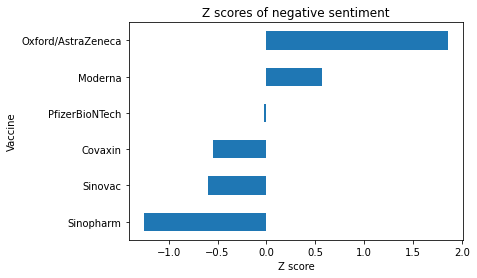

In [56]:
# Get z scores of sentiment for each vaccine
vax_names = {'Covaxin': covaxin, 'Sinovac': sinovac, 'Sinopharm': sinopharm,
            'Moderna': moderna, 'Oxford/AstraZeneca': oxford, 'PfizerBioNTech': pfizer}
sentiment_zscores = pd.DataFrame()
for k, v in vax_names.items():
    senti = v['sentiment'].value_counts(normalize=True)
    senti['vaccine'] = k
    sentiment_zscores = sentiment_zscores.append(senti)
for col in ['negative', 'neutral', 'positive']:
    sentiment_zscores[col+'_zscore'] = (sentiment_zscores[col] - sentiment_zscores[col].mean())/sentiment_zscores[col].std(ddof=0)
sentiment_zscores.set_index('vaccine', inplace=True)

# Plot the results
ax = sentiment_zscores.sort_values('negative_zscore')['negative_zscore'].plot.barh(title='Z scores of negative sentiment')
ax.set_ylabel('Vaccine')
ax.set_xlabel('Z score');

### Further analysis using 'smarter' word clouds
The final thing we will do is to generate word clouds to see which words are indicative of each sentiment. The code below is from [this notebook](https://www.kaggle.com/pawanbhandarkar/generate-smarter-word-clouds-with-log-likelihood), which contains a more detailed explanation of the methodology used to generate 'smarter' word clouds. Please go and upvote the original notebook if you find this part useful!

In [57]:
!pip install wordninja
!pip install pyspellchecker

     |████████████████████████████████| 541 kB 864 kB/s eta 0:00:01
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541553 sha256=fa5427e802ee0be5f174830e2ae21c2df02712edea585eb823f9619c5c3c59ee
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.7 MB 867 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [58]:
from wordcloud import WordCloud, ImageColorGenerator
import wordninja
from spellchecker import SpellChecker
from collections import Counter
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))  
stop_words.add("amp")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
# FUNCTIONS REQUIRED

def flatten_list(l):
    return [x for y in l for x in y]

def is_acceptable(word: str):
    return word not in stop_words and len(word) > 2

# Color coding our wordclouds 
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

# Reusable function to generate word clouds 
def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Display the generated image:
    fig, axes = plt.subplots(1,3, figsize=(20,10))
    
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Negative Words")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Neutral Words")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Positive Words")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

def get_top_percent_words(doc, percent):
    # Returns a list of "top-n" most frequent words in a list 
    top_n = int(percent * len(set(doc)))
    counter = Counter(doc).most_common(top_n)
    top_n_words = [x[0] for x in counter]
    
    return top_n_words
    
def clean_document(doc):
    spell = SpellChecker()
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize words (needed for calculating frequencies correctly )
    doc = [lemmatizer.lemmatize(x) for x in doc]
    
    # Get the top 10% of all words. This may include "misspelled" words 
    top_n_words = get_top_percent_words(doc, 0.1)

    # Get a list of misspelled words 
    misspelled = spell.unknown(doc)
    
    # Accept the correctly spelled words and top_n words 
    clean_words = [x for x in doc if x not in misspelled or x in top_n_words]
    
    # Try to split the misspelled words to generate good words (ex. "lifeisstrange" -> ["life", "is", "strange"])
    words_to_split = [x for x in doc if x in misspelled and x not in top_n_words]
    split_words = flatten_list([wordninja.split(x) for x in words_to_split])
    
    # Some splits may be nonsensical, so reject them ("llouis" -> ['ll', 'ou', "is"])
    clean_words.extend(spell.known(split_words))
    
    return clean_words

def get_log_likelihood(doc1, doc2):    
    doc1_counts = Counter(doc1)
    doc1_freq = {
        x: doc1_counts[x]/len(doc1)
        for x in doc1_counts
    }
    
    doc2_counts = Counter(doc2)
    doc2_freq = {
        x: doc2_counts[x]/len(doc2)
        for x in doc2_counts
    }
    
    doc_ratios = {
        # 1 is added to prevent division by 0
        x: math.log((doc1_freq[x] +1 )/(doc2_freq[x]+1))
        for x in doc1_freq if x in doc2_freq
    }
    
    top_ratios = Counter(doc_ratios).most_common()
    top_percent = int(0.1 * len(top_ratios))
    return top_ratios[:top_percent]

# Function to generate a document based on likelihood values for words 
def get_scaled_list(log_list):
    counts = [int(x[1]*100000) for x in log_list]
    words = [x[0] for x in log_list]
    cloud = []
    for i, word in enumerate(words):
        cloud.extend([word]*counts[i])
    # Shuffle to make it more "real"
    random.shuffle(cloud)
    return cloud

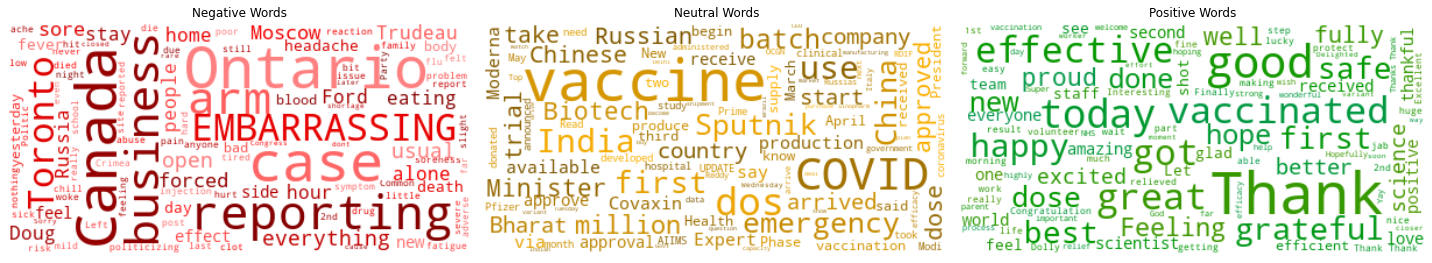

In [60]:
# Convert string to a list of words
vax_tweets['words'] = vax_tweets.text.apply(lambda x:re.findall(r'\w+', x ))

def get_smart_clouds(df):

    neg_doc = flatten_list(df[df['sentiment']=='negative']['words'])
    neg_doc = [x for x in neg_doc if is_acceptable(x)]

    pos_doc = flatten_list(df[df['sentiment']=='positive']['words'])
    pos_doc = [x for x in pos_doc if is_acceptable(x)]

    neu_doc = flatten_list(df[df['sentiment']=='neutral']['words'])
    neu_doc = [x for x in neu_doc if is_acceptable(x)]

    # Clean all the documents
    neg_doc_clean = clean_document(neg_doc)
    neu_doc_clean = clean_document(neu_doc)
    pos_doc_clean = clean_document(pos_doc)

    # Combine classes B and C to compare against A (ex. "positive" vs "non-positive")
    top_neg_words = get_log_likelihood(neg_doc_clean, flatten_list([pos_doc_clean, neu_doc_clean]))
    top_neu_words = get_log_likelihood(neu_doc_clean, flatten_list([pos_doc_clean, neg_doc_clean]))
    top_pos_words = get_log_likelihood(pos_doc_clean, flatten_list([neu_doc_clean, neg_doc_clean]))

    # Generate syntetic a corpus using our loglikelihood values 
    neg_doc_final = get_scaled_list(top_neg_words)
    neu_doc_final = get_scaled_list(top_neu_words)
    pos_doc_final = get_scaled_list(top_pos_words)

    # Visualise our synthetic corpus
    generate_word_clouds(neg_doc_final, neu_doc_final, pos_doc_final)
    
get_smart_clouds(vax_tweets)

This looks pretty good! The positive tweets appear to be from people who have just received their first vaccine or are grateful for the job scientists and healthcare workers are doing, whereas the negative tweets seem to be from people who have suffered adverse reactions to the vaccine. The neutral tweets seem to be more like news, which could explain why it is the most prevelant sentiment; in fact, the vast majority of tweets contain urls:

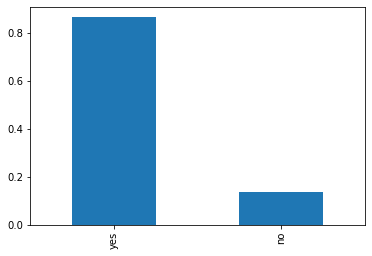

In [61]:
vax_tweets['has_url'] = np.where(vax_tweets['orig_text'].str.contains('http'), 'yes', 'no')
vax_tweets['has_url'].value_counts(normalize=True).plot.bar();

Interestingly, Canada shows up in the negative word cloud, as well as a couple of Canadian cities. Looking at a 'naive' word cloud for tweets containing 'Canada' shows us that this appears to be a political/economic issue:

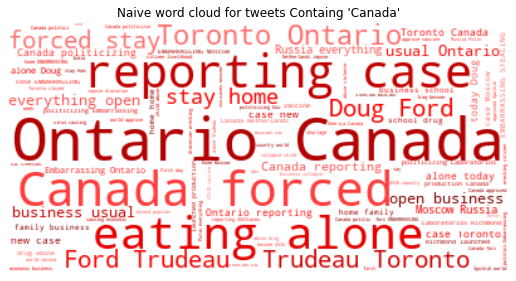

In [62]:
def get_cloud(df, string, c_func):
    string_l = string.lower()
    df[string_l] = np.where(df['text'].str.lower().str.contains(string_l), 1, 0)
    cloud_df = df.copy()[df[string_l]==1]
    doc = flatten_list(cloud_df['words'])
    doc = [x for x in doc if is_acceptable(x)]
    doc = clean_document(doc)
    fig, axes = plt.subplots(figsize=(9,5))
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(doc))
    axes.imshow(wordcloud.recolor(color_func=c_func, random_state=3), interpolation='bilinear')
    axes.set_title("Naive word cloud for tweets Containg '%s'" % (string))
    axes.axis("off")
    plt.show();
    
get_cloud(vax_tweets, 'Canada', red_color_func)

At the time of writing Canada's vaccination progress has been slower than other developed nations, and people are predicting that it [might have an impact on Canada's economic recovery](https://www.theguardian.pe.ca/news/canada/slow-vaccine-rollout-in-canada-expected-to-be-a-drag-on-economic-recovery-558857/):

In [63]:
countries = ['Canada', 'United Kingdom', 'United States', 'Chile', 'Singapore', 'Israel', 'Australia']
selected = vax_progress[vax_progress['country'].isin(countries)]
eu['country'] = 'EU median'
fig = px.line(vax_progress[vax_progress['country'].isin(countries)].append(eu), x='date', y='daily_vaccinations_per_million', color='country',
             title='Daily vaccinations per million (all vaccines) in Canada vs selected other developed nations')
fig.show()

## Conclusion
`fastai` make NLP really easy and we were able to get quite good results with a limited dataset and not a lot of training time by using the ULMFiT approach. To summarise, the steps are:
1. Fine-tune a language model to predict the next word in a tweet, using a model pre-trained on Wikipedia.
2. Fine-tune a classification model to predict tweet sentiment using the pre-trained language model.
3. Apply the classifier to unlabelled tweets to analyse sentiment.

We were also able to use the model to gain a lot of insights about how sentiment has changed over time for each vaccine and how that relates to the overall progress of vaccination programmes in different countries. I hope you found this useful, and thanks very much to [Gabriel Preda](https://www.kaggle.com/gpreda) for providing the data!